In [1]:
!pwd

/home/giakhang/dev/RDPN6D


In [1]:
import numpy as np 
import json
from PIL import Image
import torch
import matplotlib.pyplot as plt

from detectron2.config import LazyConfig, instantiate
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.structures import BoxMode

from data_utils import (
    read_image_cv2, crop_resize_by_warp_affine, my_warp_affine, get_2d_coord_np
)
from preprocess_utils import *
from lib.pysixd import inout, misc

/home/giakhang/miniconda3/envs/rdpn6d/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
config_file = './configs/gdrn/a6_cPnP.py'
cfg = LazyConfig.load(config_file)

cfg.model.weights = "./output/gdrn/lumi_piano/2025_04_16_01/model_best.pth"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
model = instantiate(cfg.model)
model = model.to(cfg.model.device)
DetectionCheckpointer(model).load(cfg.model.weights)
model.eval()

GDRN(
  (backbone): ResNetBackboneNet(
    (spatial_net): md_pointnet(
      (xyz_emb): Conv2d(512, 64, kernel_size=(1, 1), stride=(1, 1))
      (xb): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(67, 128, kernel_size=(1, 1), stride=(1, 1))
      (conv2): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
      (conv3): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
      (b1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (b2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (b3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1,

In [4]:
img_id = 3
cls_id = 0
track_id = 7
roi_idx = 1

img_path = f"./datasets/lumi_piano_dataset/data/track_{track_id:02d}/rgb/{img_id:05d}.png"
depth_path = f"./datasets/lumi_piano_dataset/data/track_{track_id:02d}/depth/{img_id:05d}.png"
cam_info_path = f"./datasets/lumi_piano_dataset/data/track_{track_id:02d}/scene_camera.json"
mask_path = f"./datasets/lumi_piano_dataset/data/track_{track_id:02d}/scene_gt_info.json"

#img_path = f"./datasets/syn_lumi_piano_dataset/data/synthetic_data2/rgb/{img_id:05d}.png"
#depth_path = f"./datasets/syn_lumi_piano_dataset/data/synthetic_data2/depth/{img_id:05d}.png" 
#cam_info_path = "./datasets/syn_lumi_piano_dataset/data/synthetic_data2/scene_camera.json"
#mask_path = "./datasets/syn_lumi_piano_dataset/data/synthetic_data2/scene_gt_info.json"

#img_path = f"./datasets/lumi_piano_external_camera/data/track_05/rgb/{img_id:05d}.png"
#depth_path = f"./datasets/lumi_piano_external_camera/data/track_05/depth/{img_id:05d}.png" 
#cam_info_path = "./datasets/lumi_piano_external_camera/data/track_05/scene_camera.json"
#mask_path = "./datasets/lumi_piano_external_camera/data/track_05/scene_gt_info.json"

cad_path = "./datasets/lumi_piano_dataset/models/obj_000001.ply"


In [5]:
with open(mask_path, 'r') as f:
    mask = json.load(f)

In [6]:
image = read_image_cv2(img_path, "BGR")

#assert image.shape[:2] == (400, 640)

im_H, im_W = image_shape = image.shape[:2]  # h, w

with open(cam_info_path, 'r') as f:
    cam_dict = json.load(f)

K = np.array(cam_dict[f"{str(img_id)}"]["cam_K"], dtype=np.float32).reshape(3, 3)

input_res = cfg.dataset_common_cfg.input_res
out_res = cfg.dataset_common_cfg.output_res

coord_2d = get_2d_coord_np(im_W, im_H, low=0, high=1).transpose(1, 2, 0)

test_bbox_type = cfg.dataset_common_cfg.test_bbox_type
bbox_key = "bbox"

In [7]:
depth_img = np.array(Image.open(depth_path)).astype(np.float32)
depth_img = depth_img / 1000
depth_img = depth_img[:, :, np.newaxis]

In [8]:
num_fps_points = cfg.dataset_common_cfg.rot_head_num_regions
objects = [
    "lumi_piano"
]

id2obj = {
    1: "lumi_piano"
}
obj2id = {_name: _id for _id, _name in id2obj.items()}

fps_points_path = "/home/giakhang/dev/RDPN6D/datasets/lumi_piano_dataset/models/fps_points.pkl"
fps_points = get_fps_points(num_fps_points, fps_points_path, objects, obj2id)[cls_id]

In [9]:
model_dir = "/home/giakhang/dev/RDPN6D/datasets/lumi_piano_dataset/models"
vertex_scale = 1
roi_extent = get_extents(objects, obj2id, model_dir, vertex_scale)[cls_id]

In [10]:
bbox = BoxMode.convert(mask[str(img_id)][roi_idx]["bbox_visib"], BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
x1, y1, x2, y2 = bbox

bbox_center = np.array([0.5 * (x1 + x2), 0.5 * (y1 + y2)])
bw = max(x2 - x1, 1)
bh = max(y2 - y1, 1)
scale = max(bh, bw) * cfg.dataset_common_cfg.dzi_pad_scale
scale = min(scale, max(im_H, im_W)) * 1.0

roi_wh = np.array([bw, bh], dtype=np.float32)
resize_ratio = out_res / scale

In [11]:
roi_img = crop_resize_by_warp_affine(
    image, bbox_center, scale, input_res, interpolation=cv2.INTER_LINEAR
).transpose(2, 0, 1)

pixel_mean = [0.0, 0.0, 0.0]
pixel_std = [255.0, 255.0, 255.0]

roi_img = normalize_image(pixel_mean, pixel_std, roi_img)

resize_ratio = out_res / scale

depth_img2 = crop_resize_by_warp_affine(
    depth_img, bbox_center, scale, input_res, interpolation=cv2.INTER_LINEAR
)
depth_img2 = depth_img2[:, :, np.newaxis]

rows, cols = 256, 256
ymap = np.array([[j for i in range(cols)]
                for j in range(rows)]).astype(np.float32)
xmap = np.array([[i for i in range(cols)]
                for j in range(rows)]).astype(np.float32)

In [12]:
H = my_warp_affine(coord_2d, bbox_center, scale,
                    input_res, interpolation=cv2.INTER_LINEAR)
offset_matrix = np.zeros((3, 3))
offset_matrix[:2, :] = H
offset_matrix[2][2] = 1

depth_img2 = depth_img2 / resize_ratio
newCameraK = np.matmul(offset_matrix, K)

cam_cx = newCameraK[0][2]
cam_cy = newCameraK[1][2]
cam_fx = newCameraK[0][0]
cam_fy = newCameraK[1][1]
xmap_masked = xmap[:, :, np.newaxis]
ymap_masked = ymap[:, :, np.newaxis]
pt2 = depth_img2.astype(np.float32)
pt0 = (xmap_masked - cam_cx) * pt2 / cam_fx
pt1 = (ymap_masked - cam_cy) * pt2 / cam_fy
depth_xyz = np.concatenate(
    (pt0, pt1, pt2), axis=2).transpose(2, 0, 1)

roi_img = np.concatenate((roi_img, depth_xyz), axis=0)

In [13]:
roi_coord_2d = crop_resize_by_warp_affine(
    coord_2d, bbox_center, scale, out_res, interpolation=cv2.INTER_LINEAR
).transpose(2, 0, 1)  # HWC -> CHW

roi_coord_2d = np.concatenate((depth_xyz[:, ::4, ::4], roi_coord_2d)).astype("float32")

In [14]:
roi_img = torch.as_tensor(np.array([roi_img])).contiguous().to("cuda", dtype=torch.float32)
roi_coord_2d = torch.as_tensor(np.array([roi_coord_2d])).contiguous().to("cuda", dtype=torch.float32)
fps = torch.as_tensor(np.array([fps_points])).contiguous().to("cuda", dtype=torch.float32)

roi_classes = torch.as_tensor(np.array([0])).to("cuda", dtype=torch.long)
K = torch.as_tensor(np.array([K])).to("cuda", dtype=torch.float32)
roi_wh = torch.as_tensor(np.array([roi_wh])).to("cuda", dtype=torch.float32)
roi_center = torch.as_tensor(np.array([bbox_center])).to("cuda", dtype=torch.float32)
resize_ratio = torch.as_tensor(np.array([resize_ratio])).to("cuda", dtype=torch.float32)
roi_extent = torch.as_tensor(np.array([roi_extent])).to("cuda", dtype=torch.float32)

In [15]:
inputs = [{
    "roi_img": roi_img,
    "roi_cls": roi_classes,
    "roi_cam": K,
    "roi_wh": roi_wh,
    "roi_center": roi_center,
    "resize_ratio": resize_ratio,
    "roi_coord_2d": roi_coord_2d,
    "roi_extent": roi_extent,
    "fps": fps
}]

rs = model.inference(inputs)

In [16]:
pred_R = rs["rot"].detach().cpu().numpy()[0]
pred_t = rs["trans"].detach().cpu().numpy()[0] 

In [17]:
(pred_t.flatten() * 1000).tolist()

[255.3505859375, -59.75544357299805, 727.1864624023438]

In [18]:
lumi_piano_model = inout.load_ply(cad_path, vertex_scale=1)

lumi_piano_model["bbox3d_and_center"] = misc.get_bbox3d_and_center(lumi_piano_model["pts"])
kpts_3d = lumi_piano_model["bbox3d_and_center"]

In [19]:
kpts_2d = misc.project_pts(kpts_3d, K.cpu().numpy()[0], pred_R, pred_t)

img = read_image_cv2(img_path, format="BGR")
img_vis_kpts2d = misc.draw_projected_box3d(img.copy(), kpts_2d)

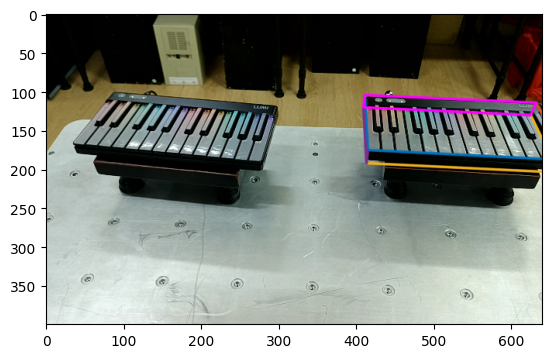

In [20]:
plt.imshow(img_vis_kpts2d[..., ::-1])